# Временные ряды

* таймсерии в курсе ODS: https://habr.com/ru/company/ods/blog/327242/  
* книжка на тему (инглиш): https://otexts.com/fpp2/  

## init

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (17,8)
plt.style.use('ggplot')

np.random.seed(42)

## data

In [4]:
days = 365
start = pd.to_datetime('2021-01-01')

data = pd.Series(
    data=np.random.randint(100, 10000, size=days),
    index=pd.date_range(
        start=start, 
        end=start + pd.Timedelta(f'{days - 1}D'), # т.к. start - тоже день. 1 + (days - 1) = days
        freq='D'
    )
)


print('rows:', data.shape[0])

data.head()

rows: 365


2021-01-01    7370
2021-01-02     960
2021-01-03    5490
2021-01-04    5291
2021-01-05    5834
Freq: D, dtype: int64

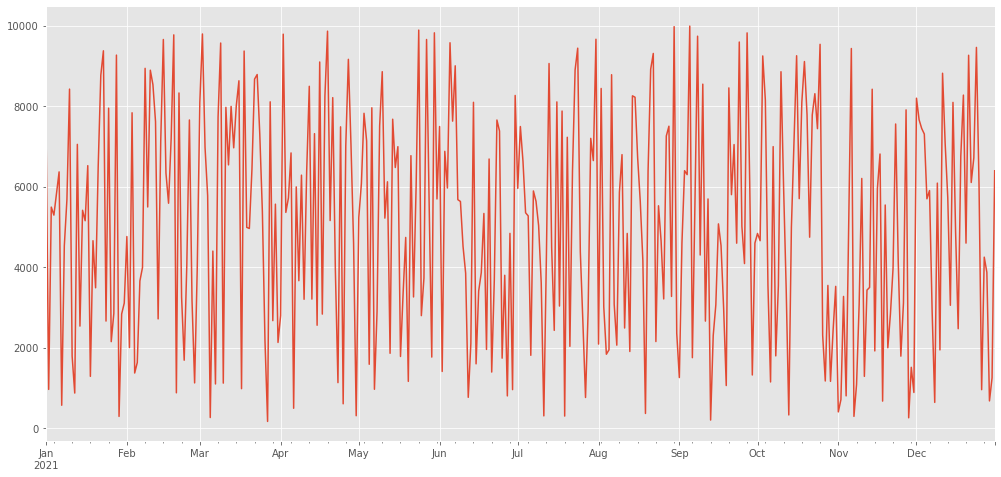

In [5]:
data.plot();

## предобработка временных рядов

### метод resample

Здесь предполагается, что даты - в индексе.  

`resample` - это аналог `groupby`. Т.е. мы преобразуем изначальный индекс к более крупным периодам (неделям, месяцам, дням если были часы и т.п.), а потом группируем по нему. Также, как к `groupby`, в итоге применяем агрегатную функцию.

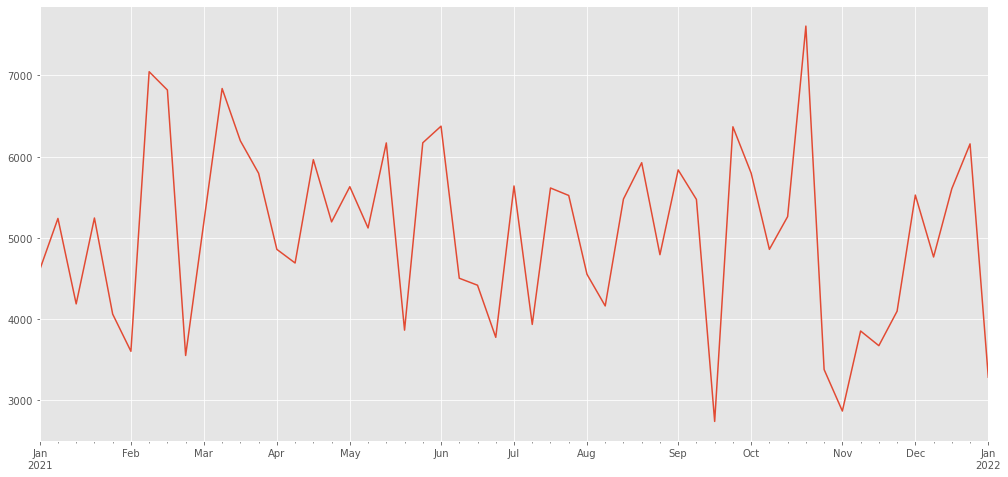

In [6]:
data.resample(
    rule='W', # к какому периоду преобразуем
    closed='left', # с какой стороны будет закрытый интервал (включительно), а с какой - нет: 'right', 'left'
    label='left', # начало или конец периода ставить как лэйбл: 'right', 'left'
    kind='period', # лейбл делать в виде периода, или таймстемпа: 'timestamp', 'period'
).mean() \
    .plot();

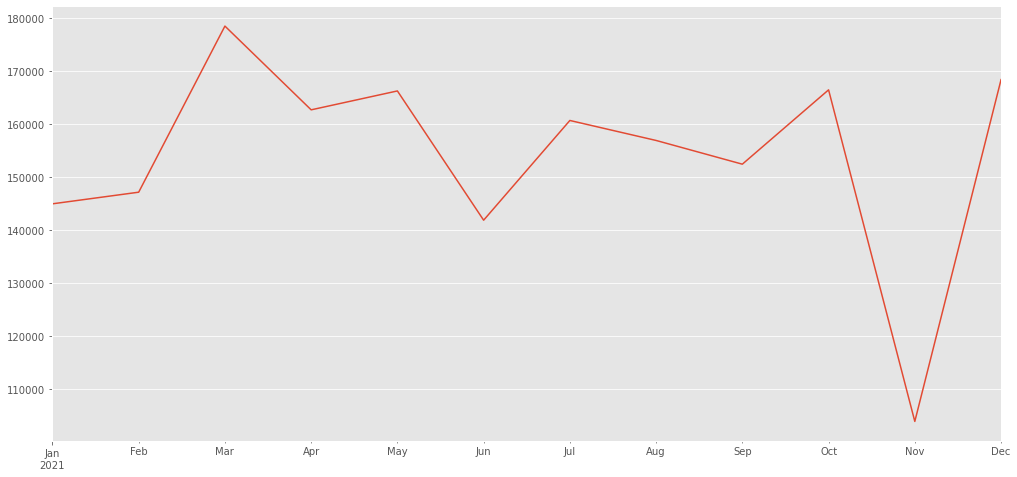

In [7]:
data.resample(
    rule='M',
    closed='right', 
    label='right', 
    kind='timestamp', 
).sum() \
    .plot();

### скользящее среднее

**Скользящее среднее** (англ. rolling mean), или **движущееся среднее** (англ. moving average), — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.  

Метод работает так: экспериментально подбирается размер окна (англ. window size) — интервал, в котором выполняют усреднение. Чем интервал больше, тем сильнее сглаживание. Затем окно начинает «скользить» почти от начала ряда к его концу, в каждой точке вычисляя среднее значение ряда и тем самым сглаживая его.  

В скользящем среднем окна «наслаиваются» друг на друга и не могут выходить за пределы ряда. Поэтому средних будет чуть меньше, чем исходных значений ряда.  

Тут также в итоге нужна агрегатная функция: вообще, `rolling` не обязательно требует `mean`.

In [9]:
data = data.to_frame(name='original')

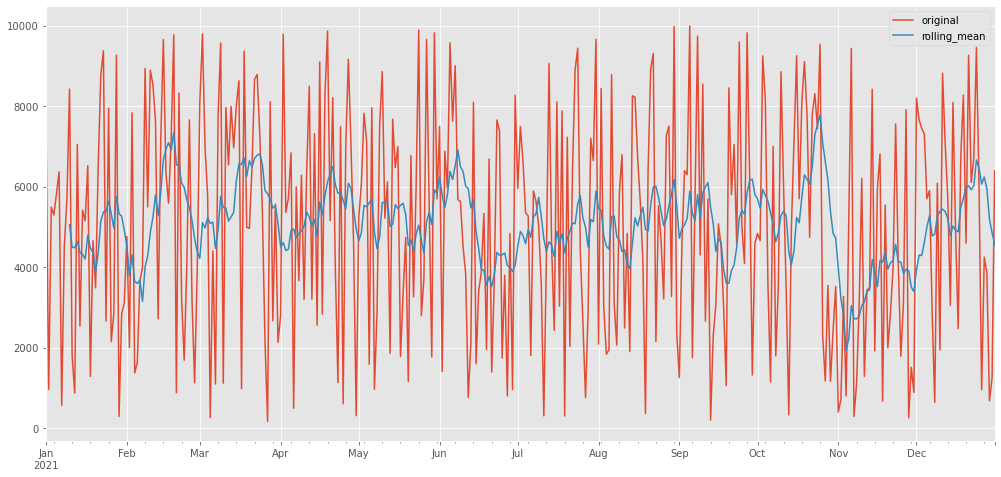

In [11]:
data['rolling_mean'] = data['original'].rolling(
    window=10, # ширина окна
    min_periods=10, # сколько NaN будет в начале. Если меньше окна - на первых будет более узкое окно считаться
    center=False # если True, значение встанет не в конец, а в центр
).mean()

data.plot();

### экспоненциальное сглаживание

Кроме скользящего (`rolling`) окна есть расширяющееся ([expanding](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.expanding.html)). Но само по себе оно нам не интересно. А интересен его взвешенный вариант: экспоненциальное взвешивание.  

Тут мы учитываем прошлое при постановке текущего значения, но с весами, затухающими в прошлое. Это позволяет избежать резких скачков вверх или вниз: прошлые значения удерживают от взлётов или провалов.

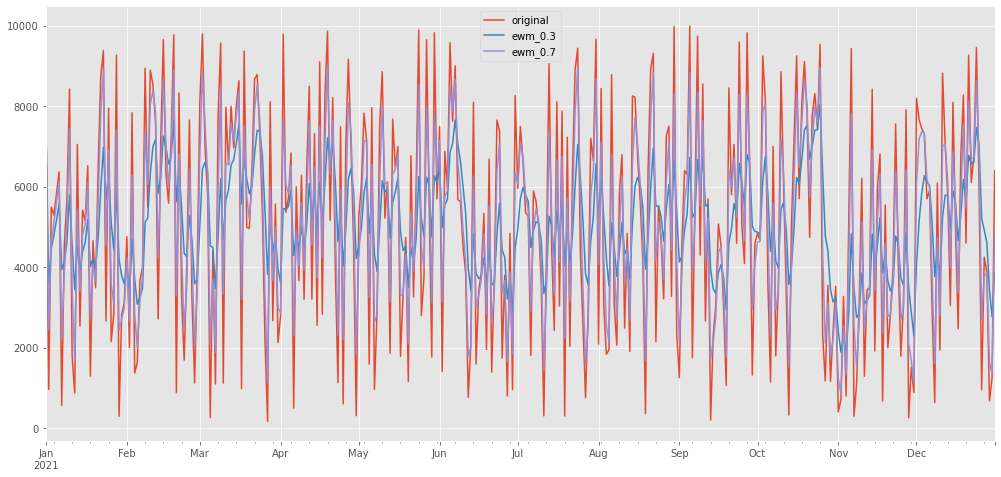

In [13]:
data['ewm_0.3'] = data['original'].ewm(
    alpha=0.3, # 0 < alpha <= 1, чем меньше alpha - тем глаже
    # есть и другие способы задать затухание: com, span, halflife
).mean()

data['ewm_0.7'] = data['original'].ewm(
    alpha=0.7, # больше alpha - веса быстрее затухают, больше вес текущего значения, ряд ближе к оригиналу
).mean()

data[['original', 'ewm_0.3', 'ewm_0.7']].plot();

### тренды и сезонность

**Тренд** (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например, ежегодное увеличение объёма продаж авиабилетов.  

**Сезонность** (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.  

Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год.

В модуле `tsa.seasonal` (от англ. time series analysis, «анализ временных рядов») библиотеки `statsmodels` (англ. «статистические модели») есть функция `seasonal_decompose()` (англ. «разбить на части»). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.  

https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

> This is a naive decomposition. More sophisticated methods should be preferred.  

> The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

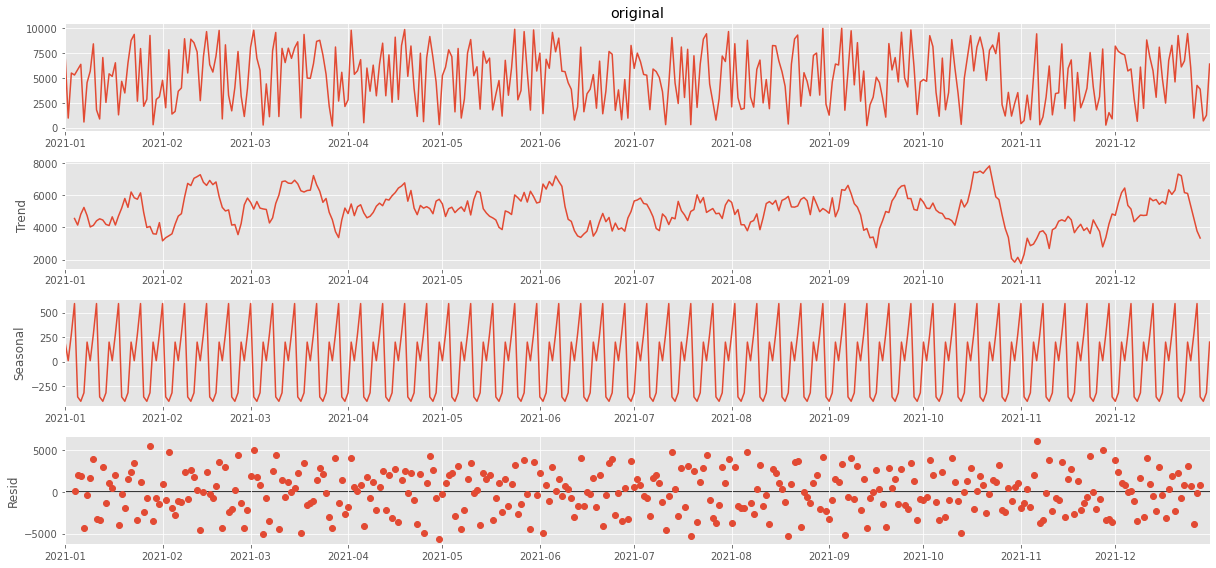

In [16]:
decomposed = seasonal_decompose(
    x=data['original'],
    model='additive' # 'additive' - Y[t] = T[t] + S[t] + e[t]; 'multiplicative' - Y[t] = T[t] * S[t] * e[t]
) 

decomposed.plot();

In [20]:
trend = decomposed.trend # pd.Series
seasonal = decomposed.seasonal # pd.Series
residuals = decomposed.resid # pd.Series

Как это делается? Как-то так: https://otexts.com/fpp2/classical-decomposition.html  

Сначала на базе скользящего среднего (только центрального) вычисляется тренд:

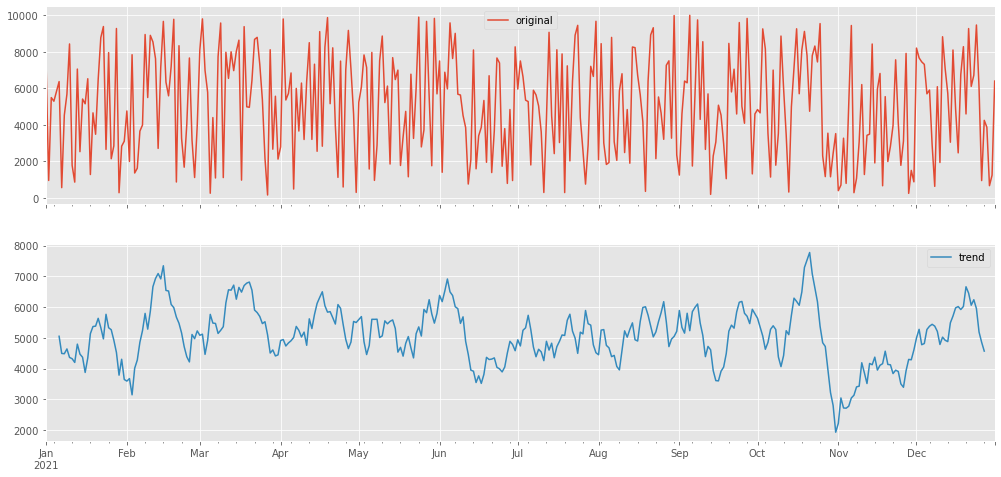

In [26]:
m = 10 # параметр, размер скользящего окна

data['trend'] = data['original'].rolling(
    window=m,
    center=True # !
).mean()

data[['original', 'trend']].plot(subplots=True);

Затем мы берем остатки:

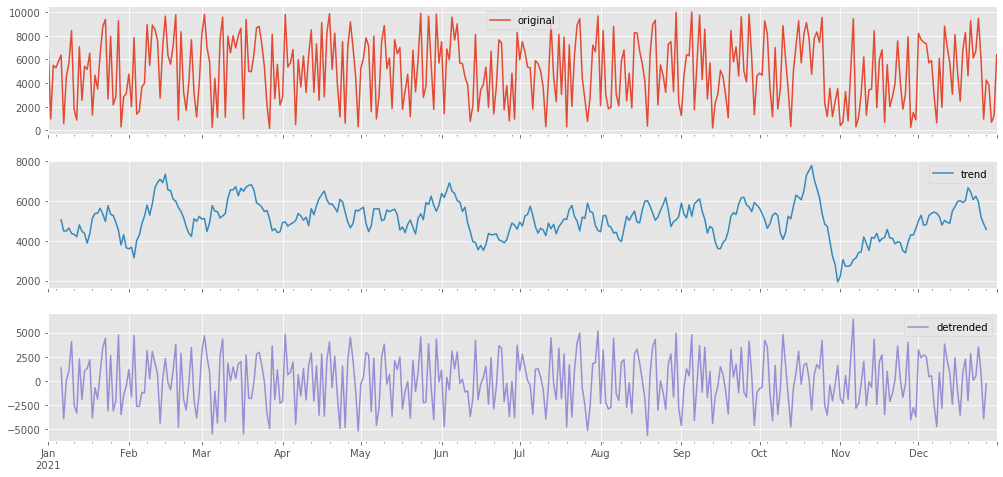

In [27]:
data['detrended'] = data['original'] - data['trend']

data[['original', 'trend', 'detrended']].plot(subplots=True);

На этих остатках считаем средние для каждого элемента периода. Например, нас интересует недельная сезонность. Тогда мы берем дни недели, и считаем среднее по всем понедельникам, и ставим его в соответствие всем понедельникам; среднее по вторникам - вторникам и т.п.  

Что-то такое:

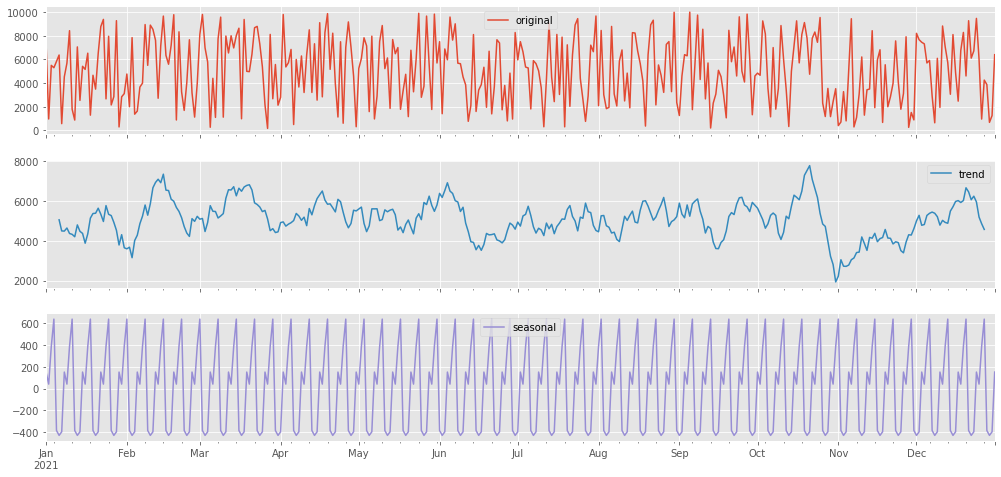

In [39]:
# какую считаем сезонность - это параметр. Возьмем неделю:
data['weekday'] = data.index.weekday

data['seasonal'] = data.groupby('weekday')['detrended'].transform('mean')

data[['original', 'trend', 'seasonal']].plot(subplots=True);

Ну и потом считаем остатки:

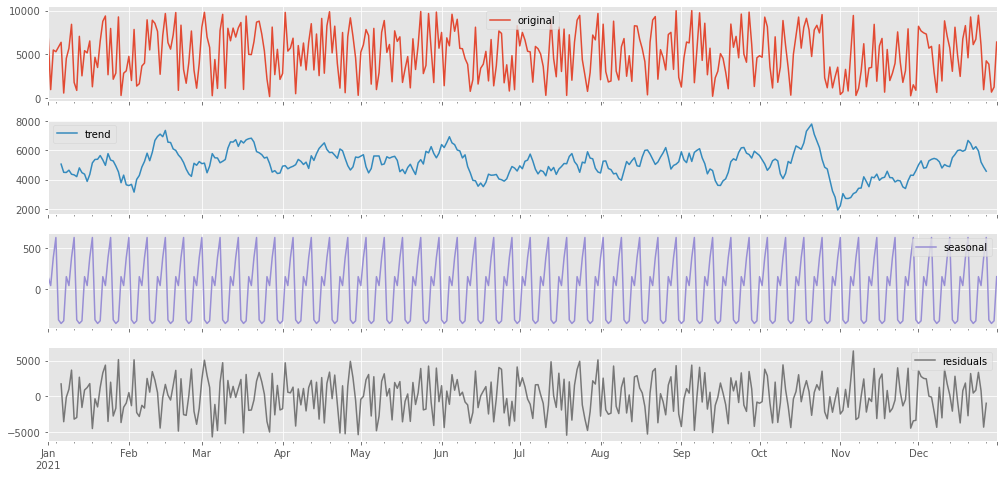

In [40]:
data['residuals'] = data['original'] - data['trend'] - data['seasonal'] # = data['detrended'] - data['seasonal']

data[['original', 'trend', 'seasonal', 'residuals']].plot(subplots=True);

И теперь можно это обратно собрать, должно совпадать с оригиналом:

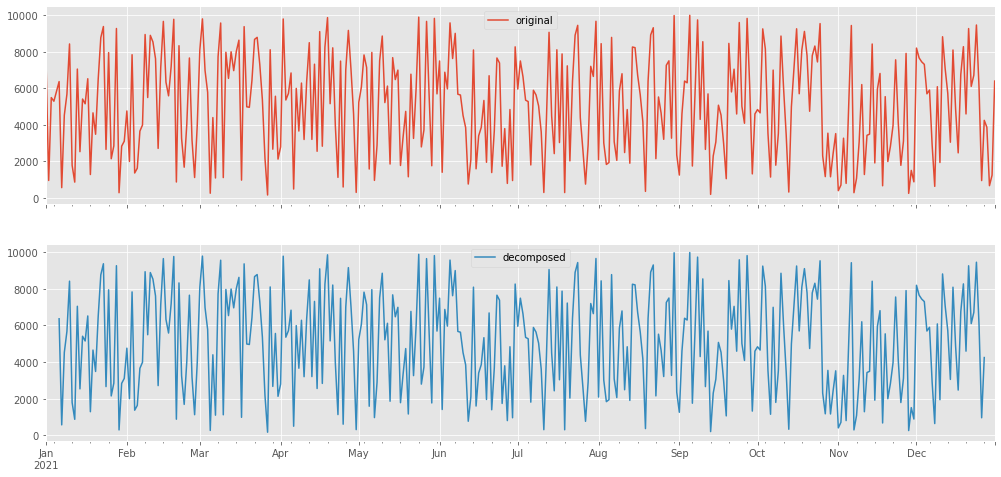

In [41]:
data['decomposed'] = data['trend'] + data['seasonal'] + data['residuals']

data[['original', 'decomposed']].plot(subplots=True);

Как мы поняли, тут многое зависит от параметров. Но в рамках самой декомпозиции их оптимизации не происходит.  

Например, в нашем случае недельная сезонность слабо выражена: там размах значений в районе 1_000 (от -500 до 500), а в остатках размах в рамках 10_000 (от -5_000 до 5_000)

Мультипликативные модели делаютя примерно также. Прикол вот в чем:  
$$Y[t] = T[t] * S[t] * e[t] \implies \log(Y[t]) = \log(T[t]) + \log(S[t]) +\log(e[t])$$  

Мультипликативные модели применяются тогда, когда вариативность по сезоном или вокруг тренда - кратная. 

### стационарные ряды

В статистике временной ряд описывается **стохастическим процессом** (англ. stochastic process). Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.  

Стохастический процесс **стационарный** (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений.  

Если распределение меняется, то процесс называется **нестационарным** (англ. nonstationary stochastic process).  

Узнать распределение временного ряда нельзя. Т.к. это не теоретическая случайная величина, а замеренные на опыте значения, выборки. Поэтому **стационарные временные ряды** (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Т.е. смотрим не на теоретические распределния, а на фактические показатели.  

Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд _«более стационарный»_, чем второй.  

**Нестационарные ряды** (англ. nonstationary time series) прогнозировать сложнее: их свойства меняются слишком быстро.

Рассмотрим пару примеров:

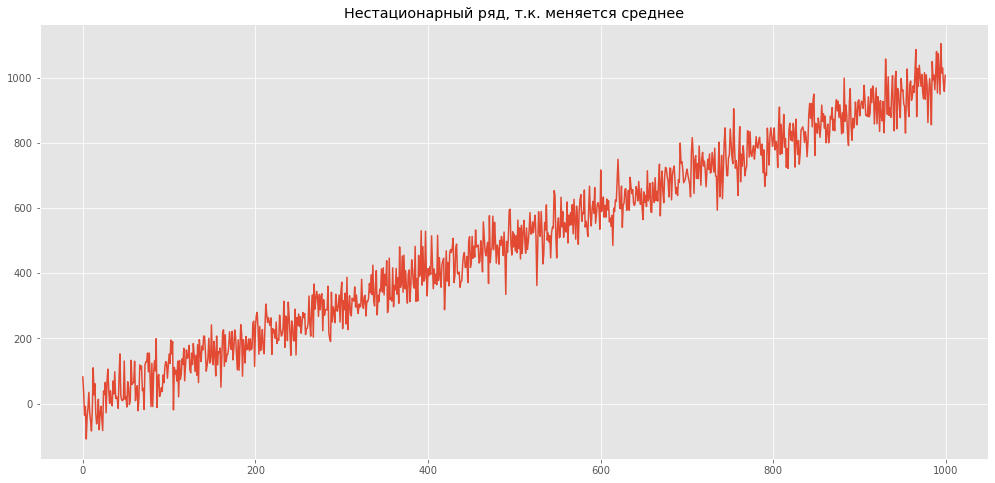

In [49]:
size = 1000

ax = plt.axes()
ax.plot(
    50 * np.random.randn(size) + np.arange(size)
)
ax.set_title('Нестационарный ряд, т.к. меняется среднее')
plt.show();

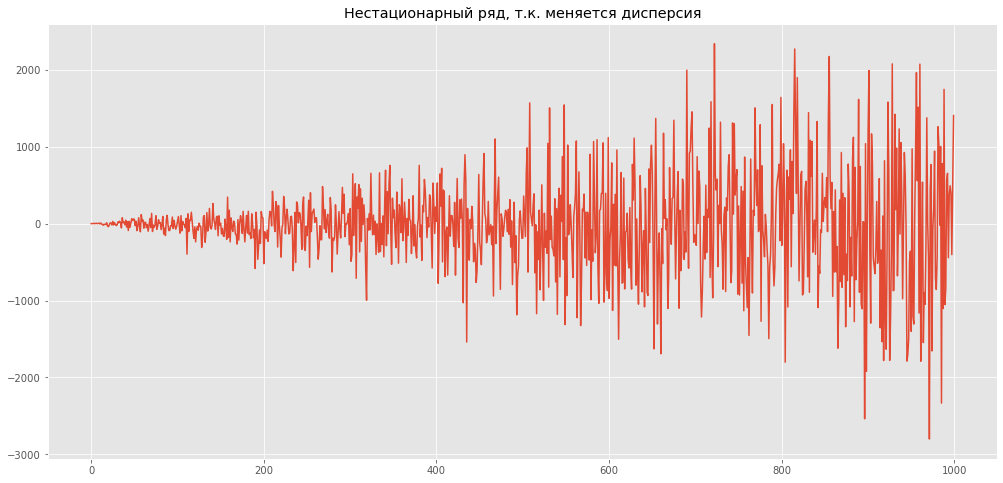

In [50]:
size = 1000

ax = plt.axes()
ax.plot(
    np.random.randn(size) * np.arange(size)
)
ax.set_title('Нестационарный ряд, т.к. меняется дисперсия')
plt.show();

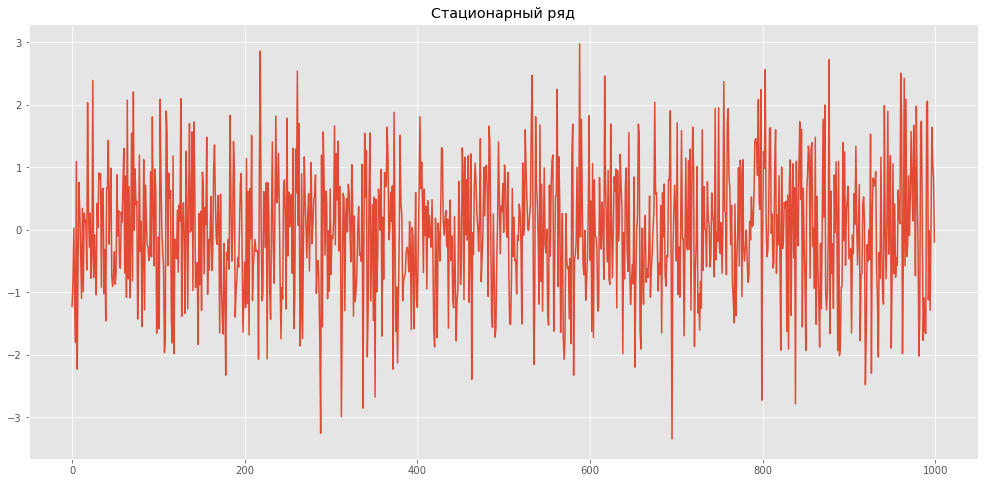

In [51]:
size = 1000

ax = plt.axes()
ax.plot(np.random.randn(size))
ax.set_title('Стационарный ряд')
plt.show();

Т.е. стационарность - это не обещание сезонности или ещё каких-то паттернов, которые облегчат прогнозирование. Это просто значит, что не будет изменения среднего во времени (тренда) и изменения дисперсии во времени

> Ещё в понятие стационарности включают **независимость ковариационной функции от времени** (должна зависеть только от расстояния между наблюдениями). Но чот это как-то сложна, я не понимаю :(  

> Постоянство условной дисперсии вектора или последовательности случайных величин (в данном случае условием является время, т.е. постоянство дисперсии во времени) называется [**гомоскедастичность**](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D0%BC%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C). А непостоянство (т.е. когда дисперсия меняется в зависимости от чего-то) - это **гетероскедастичность**. Гомоскедастичность (однородность дисперсии) случайной ошибки регрессионной модели (по отношению к предсказанию в данном случае) - обязательное условие для применения МНК

### разности временного ряда

Чтобы ряд сделать стационарным, найдём разности его значений.  

**Разности временного ряда** (англ. time series difference) — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.  

Для поиска разностей временного ряда применяется метод `shift()` (англ. «сдвиг») или `diff()`.

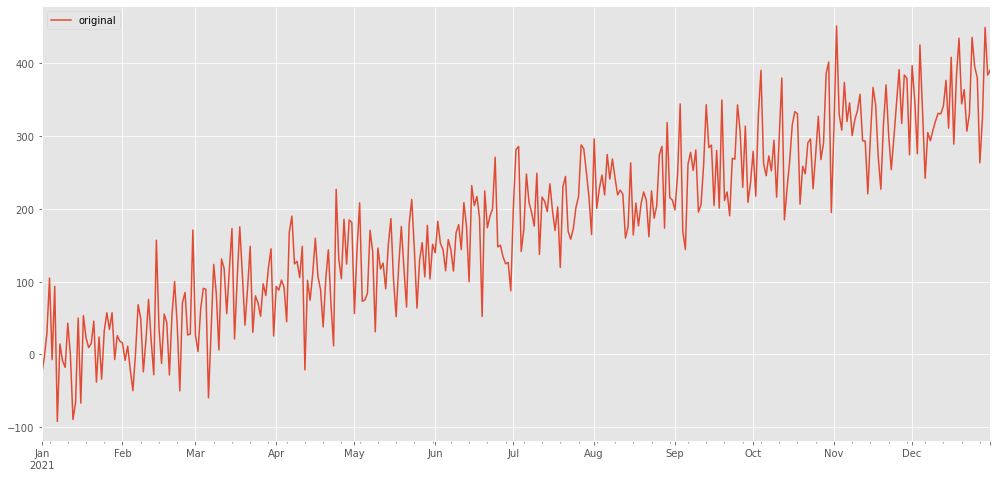

In [63]:
days = 365
start = pd.to_datetime('2021-01-01')

nonstationary_data = pd.Series(
    data=50 * np.random.randn(days) +  np.arange(days),
    index=pd.date_range(
        start=start, 
        end=start + pd.Timedelta(f'{days - 1}D'), # т.к. start - тоже день. 1 + (days - 1) = days
        freq='D'
    )
)

nonstationary_data = nonstationary_data.to_frame(name='original')

nonstationary_data.plot();

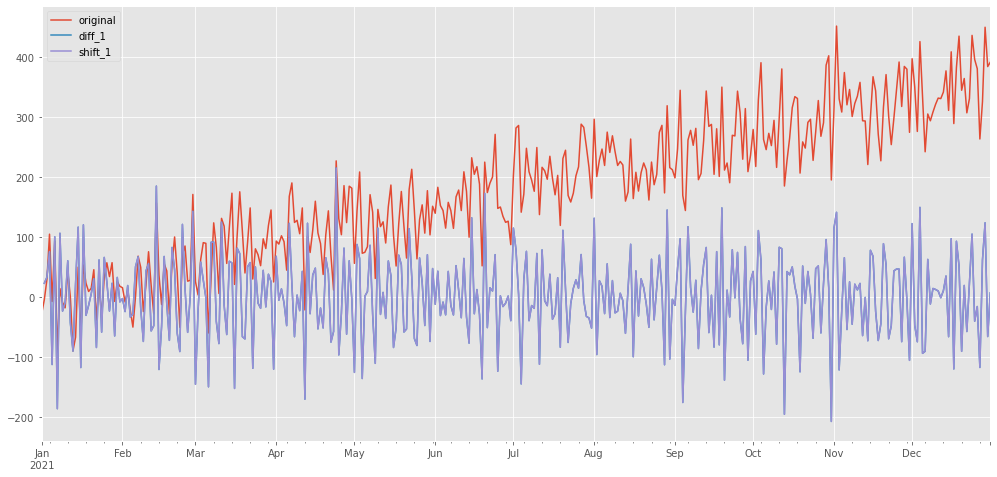

In [64]:
nonstationary_data['diff_1'] = nonstationary_data['original'].diff(
    periods=1
)

nonstationary_data['shift_1'] = nonstationary_data['original'] - nonstationary_data['original'].shift(
    periods=1
)

nonstationary_data.plot();

> Но это, по-сути, в основном с изменениями среднего работает. Изменения дисперсии это вряд ли затронет.

Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется **интегрированным первого порядка**.  

На этом строится [тест Дики-Фуллера](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0) на стационарность ряда (наличие единичного корня). Но не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.  

Бороться с нестационарностью можно множеством способов:  
* разностями различного порядка, 
* выделением тренда и сезонности, 
* сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## прогнозирование временных рядов

Задача **прогнозирования временного ряда** состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда.  

Промежуток времени в будущем, на который строится прогноз, называется **горизонтом прогнозирования** (англ. forecast horizon).  Это может быть как один шаг (прогноз только на следующий день), так и несколько на каждый день следующей недели.  

### классика

Мы можем перевести прогнозирование временных рядов в плоскость привычных нам классических табличных задач: классификации и регрессии. Если значения временного ряда, или функции  $f(t)$, где $t$ — время, — это числа, то перед вами задача регрессии для временных рядов; если категории — задача классификации. В зависимости от типа задачи будут выбираться метрики и модели.  

Остается нагенерировать из временного ряда признаки. Есть такие вароианты:  
1. Календарные признаки (англ. calendar features): год, месяц. день недели и т.п. Ибо сезонность часто связана с такими вещами: что за время года, какой день недели/час суток;  
2. «Отстающие значения» (англ. lag features): предыдущие значения временного ряда с разными окнами. Подскажут, будет ли функция $f(t)$ расти или уменьшаться. Можно получить функцией `shift()`;  
3. Скользящее среднее (конечно, без точки, в которой делаем предсказание, например сегодня - скользящее среднее на вчера): как признак задаёт общий тренд временного ряда.  

С генерацией признаков может помочь [tsfresh](https://tsfresh.readthedocs.io/en/latest/)

На этом можно строить классическую модель. Если регрессионную - то лучше, конечно, линейную: она умеет экстраполировать, в отличие от деревьев. А категории можно и не экстраполировать, так что там и деревья сойдут.

Ну и конечно сюда можно добавить всякие другие признаки, если временных рядов много. Скажем, нам надо прогнозировать спрос на товары. Мы можем посчитать по каждому товару вот эти признаки на базе временного ряда, и бонусом взять категорию товара, какие-то его характеристики, вот это всё. И на всём этом построить единую модель.

### модели для собственно временных рядов

**Тройное экспоненциальное сглаживание a.k.a. Holt-Winters**  

Описано в [статье ODS](https://habr.com/ru/company/ods/blog/327242/).  

Общий смысл - мы выделяем уровень (само значение минус сезонная компонента), тренд (рост текущего значения по отношению к предыдущему, просто разность $x_t - x_{t_1}$) и сезонность (по сезонной компоненте на период, например для недельной сезонности - 7 компонент, по одной на день недели). И их экспоненциально сглаживаем.  

Благодаря сезонной компоненте можем предсказывать на сколько угодно вперед. Двойное экспоненциальное сглаживаение, где только уровень и тренд, предсказыват на 2 шага вперед; обычное экспоненциальное сглаживаение, где только уровень - на 1 шаг.  

Есть параметры: длина сезона (читай кол-во сезонных компонент) и три коэффициента затухания, по одному для каждой компоненты (уровня, тренда и сезона). Их можно подбирать на кроссвалидации.  

Особой оптимизации тут нет. Так что это не то чтобы прям машинное обучение.  

Реализовано в `statsmodels`: [`statsmodels.tsa.holtwinters.ExponentialSmoothing`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

**ARIMA/SARIMA**  

Та же [статья ODS](https://habr.com/ru/company/ods/blog/327242/) + ещё парочка: [1](https://habr.com/ru/post/207160/), [2](https://habr.com/ru/post/210530/)  

[Объяснение ин инглиш](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8)  

ARIMA - Auto Regressive Integrated Moving Average  

Т.е. тут используется три идеи:  
* авторегрессия - это попытка построить предсказание (классической линейной регрессией) на лагах;  
* интегрированный ряд - разности для бОльшей стационарности;  
* скользящее среднее - классика, среднее по окну.  

**S** в SARIMA - сезонный компонент в дополнение к ARIMA  

Также надо передавать гиперпараметры.

Общее резюме - предсказывает неплохо, но надо поработать с данными: определить подходящую разность, лаги для авторегрессии, вот это всё.  

Также реализовано в `statsmodels`: [`statsmodels.tsa.arima.model.ARIMA`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

**Facebook Prophet**  

* [docs](https://facebook.github.io/prophet/docs/quick_start.html#python-api)  
* [Статья на Хабре](https://habr.com/ru/company/ods/blog/323730/)  

По сути, это _additive regression model_, состоящая из следующих компонент:  
$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$  

* Сезонные компоненты $s(t)$ отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Недельная сезонность моделируется с помощью dummy variables. Добавляются 6 дополнительных признаков, например, [monday, tuesday, wednesday, thursday, friday, saturday], которые принимают значения 0 и 1 в зависимости от даты. Признак sunday, соответствующий седьмому дню недели, не добавляют, потому что он будут линейно зависеть от других дней недели и это будет влиять на модель. Годовая же сезонность моделируется рядами Фурье.  
* Тренд $g(t)$ — это кусочно-линейная или логистическая функция. С линейной функцией все понятно. Логистическая же функция вида $g(t) = \frac{C}{1+exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. Типичный пример — это рост аудитории приложения или сайта. Кроме всего прочего, библиотека умеет по историческим данным выбирать оптимальные точки изменения тренда. Но их также можно задать и вручную (например, если известны даты релизов новой функциональности, которые сильно повлияли на ключевые показатели).  
* Компонента $h(t)$ отвечает за заданные пользователем аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.
* Ошибка $\epsilon_{t}$ содержит информацию, которая не учтена моделью.  

Подходит для прогнозирования сразу многих рядов, быстро, удобно, хорошие показатели.

## Общие советы

В общем, обычно у нас очень много рядов. Например, много товаров, и надо по каждому предсказывать спрос или цены. Что делать?  

Строить по каждому SARIMA - нереально. Да и обычно есть ещё признаки, не только старые значения ряда.  

Ну, хорошо если удастся кластеризовать ряды. Например, товары одной категории (просто разные бренды) будут иметь примерно равные цены и похожие сезонности. Для них можно посчитать тренд (линейной моделью, или какое-нибудь скользящее среднее, которое потом прогнозировать собственно таймсериесными моделями), а отклонения от этого тренда предсказывать бустингом.  

Другой вариант - генерим фичи по времени (см. п. 4.1), добавляем доп. фичи, и на всём строим обычные модели.  

Ещё можно деревом решений (прям одним, не лесом или бустингом) побить на листы, а в них, в листах, строить линейные модели.

In [66]:
from datetime import datetime

In [71]:
datetime(2020, 1, 1).date().isoformat()

'2020-01-01'